# I. Introduction/Business Problem

This project will be a way of comparing colleges. The user will be able to perform comparison and clustering based on details about the universities themselves (including tuition/fees, acceptance rate, student body size, etc.) as well as attractions in the cities in which they are located.

I will specifically be working with the eight Ivy League schools (Brown University, Columbia University, Cornell University, Dartmouth College, Harvard University, Princeton University, University of Pennsylvania, and Yale University), however the code could be easily modified to compare other universities/cities.

This tool is designed to help students make choices about which university to attend.

# II. Data

# University Data
For this project, I will be obtaining data on the universities themselves data from these two URLs:
http://blog.collegetuitioncompare.com/2015/05/ivy-league-2015-2016-estimated-tuition.html
https://www.collegetuitioncompare.com/best-schools/ivy-league/
From these two sources, I can use webscraping to obtain information about 2020 tuition/fees and on-campus housing costs, as well as the acceptance rates, SAT scores, graduation rate, and student/faculty ratio. All of these pieces of information could be useful to a prospective student trying to choose a university.

### Key Facts

In [1]:
import pandas as pd
import numpy as np
import random # library for random number generation
import requests
import lxml.html as lh
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
print('Imported!')


Imported!


In [2]:
#import key facts dataset
url='http://blog.collegetuitioncompare.com/2015/05/ivy-league-2015-2016-estimated-tuition.html'
page = requests.get(url)
doc = lh.fromstring(page.content)

#parse table1
tr_elements = doc.xpath('//tr')
table1 = []

for t in tr_elements: #only want data from the first table (which has 6 columns) and not the second table (which has 3 columns)
    if len(t) == 6:
        table1.append(t)
        
#[len(T) for T in table1] #confirm only data from first table


In [3]:
#get table headers
col=[]
for t in table1[0]:
        name=t.text_content()
        col.append((name.strip('\n'),[]))

#fill out table
for j in range(1,len(table1)):
    #T is our j'th row
    T=table1[j]    
    i=0
    for t in T.iterchildren():
        data=t.text_content()
        col[i][1].append(data)
        #Increment i for the next column
        i+=1   

#create df
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [4]:
df.drop([8], inplace = True) #delete averages row

#clean up 'name' column by splitting into university name and city name
oldnames = df['Name']
cities = []
names = []
for name in oldnames:
    split = name.splitlines()
    cities.append(split[1].strip())
    names.append(split[0])
df['Name'] = names
df['City'] = cities
df.set_index('Name', inplace = True) #index by name

df

,Acceptance Rate,SAT Score,Graduation Rate,Population,Student-Faculty Ratio,City
Name,,,,,,
Brown University,8%,"1,485",95%,"10,257",6:1 (16.67 %),"Providence, RI"
Columbia University in the City of New York,6%,"1,505",96%,"31,077",6:1 (16.67 %),"New York, NY"
Cornell University,11%,"1,465",95%,"23,600",9:1 (11.11 %),"Ithaca, NY"
Dartmouth College,9%,"1,490",95%,"6,572",7:1 (14.29 %),"Hanover, NH"
Harvard University,5%,"1,520",98%,"31,566",7:1 (14.29 %),"Cambridge, MA"
Princeton University,5%,"1,505",96%,"8,374",5:1 (20.00 %),"Princeton, NJ"
University of Pennsylvania,8%,"1,485",95%,"25,860",6:1 (16.67 %),"Philadelphia, PA"
Yale University,6%,"1,515",97%,"13,433",6:1 (16.67 %),"New Haven, CT"


### Tuition and Housing Costs

In [5]:
#import tuition and cost of living dataset
url='https://www.collegetuitioncompare.com/best-schools/ivy-league/'
page = requests.get(url)
doc = lh.fromstring(page.content)

#parse table2
table2 = doc.xpath('//tr')
        
#[len(T) for T in table2] #confirm only data from table

In [6]:
#get table headers
col=[]
for t in table2[0]:
        name=t.text_content()
        col.append((name.strip('\n'),[])) 
print(col)

[('School Name', []), ('Undergraduate Tuition & Fees', []), ('Graduate Tuition & Fees', []), ('Living Costs', [])]


In [7]:
#didn't quite work because of the subheaders, need to fix
del col[-1]
for t in table2[1]:
        name=t.text_content()
        col.append((name.strip('\n'),[])) 
print(col)

[('School Name', []), ('Undergraduate Tuition & Fees', []), ('Graduate Tuition & Fees', []), ('On-Campus', []), ('Off-Campus', [])]


In [8]:
#fill out table
for j in range(2,len(table2)):
    #T is our j'th row
    T=table2[j]    
    i=0
    for t in T.iterchildren():
        data=t.text_content()
        col[i][1].append(data.strip())
        #Increment i for the next column
        i+=1

#create df
Dict={title:column for (title,column) in col}
df2=pd.DataFrame(Dict)

#df2

In [9]:
df2.drop([8], inplace = True) #delete average
df2.drop(columns=['Off-Campus'], inplace = True)#delete off-campus living expenses due to incomplete information
df2.rename(columns={'On-Campus': 'Cost of Living (On-Campus)', 'School Name': 'Name'}, inplace = True) #clarify column name
df2.set_index('Name', inplace = True) #index by school name
df2

,Undergraduate Tuition & Fees,Graduate Tuition & Fees,Cost of Living (On-Campus)
Name,,,
Brown University,"$58,404","$58,180","$17,454"
Columbia University in the City of New York,"$61,788","$49,968","$16,670"
Cornell University,"$57,222","$29,585","$18,066"
Dartmouth College,"$57,638","$55,947","$18,414"
Harvard University,"$51,925","$49,214","$20,875"
Princeton University,"$52,800","$53,770","$20,300"
University of Pennsylvania,"$57,770","$40,182","$18,136"
Yale University,"$55,500","$43,300","$20,095"


### Combined Dataframe of All University Data

In [10]:
df_schools = pd.concat([df, df2], axis=1, sort=True)
df_schools['Latitude'] = np.nan
df_schools['Longitude'] = np.nan
df_schools

,Acceptance Rate,SAT Score,Graduation Rate,Population,Student-Faculty Ratio,City,Undergraduate Tuition & Fees,Graduate Tuition & Fees,Cost of Living (On-Campus),Latitude,Longitude
Name,,,,,,,,,,,
Brown University,8%,"1,485",95%,"10,257",6:1 (16.67 %),"Providence, RI","$58,404","$58,180","$17,454",NaN,NaN
Columbia University in the City of New York,6%,"1,505",96%,"31,077",6:1 (16.67 %),"New York, NY","$61,788","$49,968","$16,670",NaN,NaN
Cornell University,11%,"1,465",95%,"23,600",9:1 (11.11 %),"Ithaca, NY","$57,222","$29,585","$18,066",NaN,NaN
Dartmouth College,9%,"1,490",95%,"6,572",7:1 (14.29 %),"Hanover, NH","$57,638","$55,947","$18,414",NaN,NaN
Harvard University,5%,"1,520",98%,"31,566",7:1 (14.29 %),"Cambridge, MA","$51,925","$49,214","$20,875",NaN,NaN
Princeton University,5%,"1,505",96%,"8,374",5:1 (20.00 %),"Princeton, NJ","$52,800","$53,770","$20,300",NaN,NaN
University of Pennsylvania,8%,"1,485",95%,"25,860",6:1 (16.67 %),"Philadelphia, PA","$57,770","$40,182","$18,136",NaN,NaN
Yale University,6%,"1,515",97%,"13,433",6:1 (16.67 %),"New Haven, CT","$55,500","$43,300","$20,095",NaN,NaN


In [11]:
#change all values to floats with no extra characters
for percentage in df_schools['Acceptance Rate']:
    decimal = percentage.replace('%', '')
    decimal = float(decimal) / 100.0
    idx = df_schools.loc[df_schools['Acceptance Rate'] == percentage].index[0]
    df_schools.at[idx, 'Acceptance Rate'] = decimal

for percentage in df_schools['Graduation Rate']:
    decimal = percentage.replace('%', '')
    decimal = float(decimal) / 100.0
    idx = df_schools.loc[df_schools['Graduation Rate'] == percentage].index[0]
    df_schools.at[idx, 'Graduation Rate'] = decimal

for string in df_schools['SAT Score']:
    value = string.replace(',', '')
    value = float(value)
    idx = df_schools.loc[df_schools['SAT Score'] == string].index[0]
    df_schools.at[idx, 'SAT Score'] = value

for string in df_schools['Population']:
    value = string.replace(',', '')
    value = float(value)
    idx = df_schools.loc[df_schools['Population'] == string].index[0]
    df_schools.at[idx, 'Population'] = value

for cost in df_schools['Undergraduate Tuition & Fees']:
    value = cost.replace('$', '')
    value = value.replace(',', '')
    value = float(value)
    idx = df_schools.loc[df_schools['Undergraduate Tuition & Fees'] == cost].index[0]
    df_schools.at[idx, 'Undergraduate Tuition & Fees'] = value
                
for cost in df_schools['Graduate Tuition & Fees']:
    value = cost.replace('$', '')
    value = value.replace(',', '')
    value = float(value)
    idx = df_schools.loc[df_schools['Graduate Tuition & Fees'] == cost].index[0]
    df_schools.at[idx, 'Graduate Tuition & Fees'] = value 
                                            
for cost in df_schools['Cost of Living (On-Campus)']:
    value = cost.replace('$', '')
    value = value.replace(',', '')
    value = float(value)
    idx = df_schools.loc[df_schools['Cost of Living (On-Campus)'] == cost].index[0]
    df_schools.at[idx, 'Cost of Living (On-Campus)'] = value 

for ratio in df_schools['Student-Faculty Ratio']:
    percentage = ratio.split()[1]
    percentage = percentage.replace('(', '')
    decimal = float(percentage) / 100.0
    idx = df_schools.loc[df_schools['Student-Faculty Ratio'] == ratio].index[0]
    df_schools.at[idx, 'Student-Faculty Ratio'] = decimal

#set all types to floats    
df_schools

,Acceptance Rate,SAT Score,Graduation Rate,Population,Student-Faculty Ratio,City,Undergraduate Tuition & Fees,Graduate Tuition & Fees,Cost of Living (On-Campus),Latitude,Longitude
Name,,,,,,,,,,,
Brown University,0.08,1485,0.95,10257,0.1667,"Providence, RI",58404,58180,17454,NaN,NaN
Columbia University in the City of New York,0.06,1505,0.96,31077,0.1667,"New York, NY",61788,49968,16670,NaN,NaN
Cornell University,0.11,1465,0.95,23600,0.1111,"Ithaca, NY",57222,29585,18066,NaN,NaN
Dartmouth College,0.09,1490,0.95,6572,0.1429,"Hanover, NH",57638,55947,18414,NaN,NaN
Harvard University,0.05,1520,0.98,31566,0.1429,"Cambridge, MA",51925,49214,20875,NaN,NaN
Princeton University,0.05,1505,0.96,8374,0.2,"Princeton, NJ",52800,53770,20300,NaN,NaN
University of Pennsylvania,0.08,1485,0.95,25860,0.1667,"Philadelphia, PA",57770,40182,18136,NaN,NaN
Yale University,0.06,1515,0.97,13433,0.1667,"New Haven, CT",55500,43300,20095,NaN,NaN


# City Data
I will be using Foursquare location data to explore the attractions/amenities nearby each of the universities. This would be helpful for students looking to narrow their choices based on the type of city they'd like to live in: Is it important to them to have lots of restaurants nearby? Or museums? Or parks? Or music venues? To start, I will simply find the latitude/longitude location of each university and put them on a map. Later, I can use these locations to find nearby venues.

In [12]:
CLIENT_ID = '1EYLQ4F433HOJVY25WXUIBIRZIT3TO4Q5LEUNWOLUR2DVA5P' # your Foursquare ID
CLIENT_SECRET = 'C5ZML2CGZU32FZNPBA0Y0ZRB51IFH5JQMZAKVCMN00TUALRR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
OAUTH_TOKEN = 'UPCXPV0RHXZHH1KY3K2NTFL0M3WCUQSPHC04NYLYCOOFTIMB'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 1EYLQ4F433HOJVY25WXUIBIRZIT3TO4Q5LEUNWOLUR2DVA5P
CLIENT_SECRET:C5ZML2CGZU32FZNPBA0Y0ZRB51IFH5JQMZAKVCMN00TUALRR


In [13]:
categoryid = '4bf58dd8d48988d1ae941735' #category for universities
limit = 1
addresses = {}
for name in df_schools.index:
    city = df_schools.loc[name,'City']
    # create the API request URL
    #https://api.foursquare.com/v2/venues/search?near=new york, ny&categoryId=4d4b7105d754a06374d81259&query=starbucks&client_id=your_client_id&client_secret=your_client_secret
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={},&v={}&categoryId={}&query={}&near={}&oauth_token={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            categoryid,
            name,
            city,
            OAUTH_TOKEN,
            limit)          
    # make the GET request
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venue = results['response']['venues']
    dataframe = pd.json_normalize(venue)
    addresses[name] = [dataframe.loc[0,'location.lat'], dataframe.loc[0,'location.lng']]
    df_schools.at[name, 'Latitude'] = dataframe.loc[0,'location.lat']
    df_schools.at[name, 'Longitude'] = dataframe.loc[0,'location.lng']

df_schools

,Acceptance Rate,SAT Score,Graduation Rate,Population,Student-Faculty Ratio,City,Undergraduate Tuition & Fees,Graduate Tuition & Fees,Cost of Living (On-Campus),Latitude,Longitude
Name,,,,,,,,,,,
Brown University,0.08,1485,0.95,10257,0.1667,"Providence, RI",58404,58180,17454,41.826148,-71.404674
Columbia University in the City of New York,0.06,1505,0.96,31077,0.1667,"New York, NY",61788,49968,16670,40.807619,-73.962367
Cornell University,0.11,1465,0.95,23600,0.1111,"Ithaca, NY",57222,29585,18066,42.447505,-76.483603
Dartmouth College,0.09,1490,0.95,6572,0.1429,"Hanover, NH",57638,55947,18414,43.703747,-72.289352
Harvard University,0.05,1520,0.98,31566,0.1429,"Cambridge, MA",51925,49214,20875,42.373711,-71.117264
Princeton University,0.05,1505,0.96,8374,0.2,"Princeton, NJ",52800,53770,20300,40.348158,-74.659310
University of Pennsylvania,0.08,1485,0.95,25860,0.1667,"Philadelphia, PA",57770,40182,18136,39.952056,-75.195065
Yale University,0.06,1515,0.97,13433,0.1667,"New Haven, CT",55500,43300,20095,41.311007,-72.926121


In [14]:
# create map of Ivy League schools using latitude and longitude values
map_ivy = folium.Map(location=addresses['Brown University'], zoom_start=7)

# add markers to map
for lat, lng, city, school in zip(df_schools['Latitude'], df_schools['Longitude'], df_schools['City'], df_schools.index):
    label = '{}, {}'.format(school, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ivy)  
    
map_ivy

# III. Methodology

## Initial Cluster Analysis
The first step will be to narrow the student's choices by performing an initial cluster analysis of the attributes listed in the above section. The universities will be grouped based in similarities in acceptance rate, SAT scores, graduation rate, student/faculty ratio, population size, and cost. Based on these clusters, the student can choose which type of university they're most interested in attending (easier to get into or more elite, smaller or larger student body, lower tuition, lower cost to live on-campus, etc). Next, the student can create a "shortlist" consisting of as many schools as they would like to examine more closely.

## Within-Cluster Analysis
Once the student has selected the cluster(s) they're interested in investigating further, they can begin to explore the surrounding area to determine if a particular location is more or less appealing than the others. I kept the exploration radius to 1 mile (reasonable walking-distance from campus).
### Comparing Venue Categories
The student can do a search that returns all types of venues, but I found it more productive to search by venue type. I included searches on food venues, arts/entertainment venues, and outdoor/recreation venues. I found this method to allow for better comparisons between the cities; when searching through all venues, the vast majority of the top venues were restaurants, which made it difficult to learn more about the other types of venues.
### Exploring Most Popular Venues
Within each venue type, the student can view the 'n' most popular types of venues within that category. I found 10 to be a good number, as numbers greater than that can become confusing. Additionally, if you set 'n' too high and a city doesn't have at least 'n' unique venue types in that category, the city may not actually have any of the nth most popular venue type.
### Comparing Specific Venues Between Cities
If a student has a particular interest--such as the performing arts, physical fitness, outdoor activities, a specific cuisine, etc.--they can compare those venue types directly. I performed such a comparison on different kinds of museums, performing arts venues, and outdoor/nature venues. Because we are now comparing only a few venue types in a limited number of cities, the clearest way to view the results is with a bar chart comparing the relative quantities of each venue type in each city.

# IV. Results

## Initial Cluster Analysis

The first step will be to cluster the schools based on the data we've gathered so far.

In [15]:
#save lat and long columns for later
df_coords = df_schools[['Latitude', 'Longitude']]

#remove columns not relevant to clustering
df_clustering = df_schools.drop(columns=['City','Latitude','Longitude'])

#set all types to floats    
df_clustering= df_clustering.astype("float")
df_clustering

,Acceptance Rate,SAT Score,Graduation Rate,Population,Student-Faculty Ratio,Undergraduate Tuition & Fees,Graduate Tuition & Fees,Cost of Living (On-Campus)
Name,,,,,,,,
Brown University,0.08,1485.0,0.95,10257.0,0.1667,58404.0,58180.0,17454.0
Columbia University in the City of New York,0.06,1505.0,0.96,31077.0,0.1667,61788.0,49968.0,16670.0
Cornell University,0.11,1465.0,0.95,23600.0,0.1111,57222.0,29585.0,18066.0
Dartmouth College,0.09,1490.0,0.95,6572.0,0.1429,57638.0,55947.0,18414.0
Harvard University,0.05,1520.0,0.98,31566.0,0.1429,51925.0,49214.0,20875.0
Princeton University,0.05,1505.0,0.96,8374.0,0.2000,52800.0,53770.0,20300.0
University of Pennsylvania,0.08,1485.0,0.95,25860.0,0.1667,57770.0,40182.0,18136.0
Yale University,0.06,1515.0,0.97,13433.0,0.1667,55500.0,43300.0,20095.0


In [16]:
#scale values for easier computation
X = df_clustering.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

#set number of clusters
num_clusters = 4

#cluster dataset
k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

#add labels for clusters to dataframe then display mean values for each cluster
df_clustering["Labels"] = labels
df_clustering.groupby('Labels').mean()

,Acceptance Rate,SAT Score,Graduation Rate,Population,Student-Faculty Ratio,Undergraduate Tuition & Fees,Graduate Tuition & Fees,Cost of Living (On-Campus)
Labels,,,,,,,,
0,0.085000,1487.500000,0.950,8414.5,0.154800,58021.000000,57063.500000,17934.000000
1,0.053333,1513.333333,0.970,17791.0,0.169867,53408.333333,48761.333333,20423.333333
2,0.070000,1495.000000,0.955,28468.5,0.166700,59779.000000,45075.000000,17403.000000
3,0.110000,1465.000000,0.950,23600.0,0.111100,57222.000000,29585.000000,18066.000000


### Map Showing Clusters

In [17]:
#add coordinates back to dataframe for mapping purposes
df_clustering = pd.concat([df_clustering, df_coords], axis=1, sort=True)

# create map of clusters
map_clusters = folium.Map(location=addresses['Brown University'], zoom_start=7)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, school, cluster in zip(df_clustering['Latitude'], df_clustering['Longitude'], df_clustering.index, df_clustering['Labels']):
    label = folium.Popup(str(school) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Initial Cluster Results
Group A (Harvard, Yale, and Princeton)
- lowest acceptance rate
- highest SAT scores 
- has highest graduation rate

- midsize student popoulation (Harvard is larger, Yale and Princeton are smaller)

- lowest tuition for both undergraduate and graduate students
- highest cost to live on-campus

- SUMMARY: Most elite and difficult to get accepted at

Group B (Columbia and UPenn)
- second lowest acceptance rate
- second highest SAT scores

- largest student population

- highest undergrad tuition, medium graduate tuition
- low cost to live on-campus 

- SUMMARY: Somewhat difficult to get accepted, good if you like large student bodies

Group C (Brown and Dartmouth)
- second highest acceptance rate
- second lowest SAT scores

- smallest student population

- high tuition for graduate and undergraduate students
- low cost to live on-campus

- SUMMARY: Easier to get into, good if you like very small student bodies


Group D (Cornell)
- highest acceptance rate
- lowest SAT scores

- large student population
- worst faculty-student ratio

- lowest graduate tuition, fairly high undergraduate tuition
- fairly low cost to live on-campus

- SUMMARY: Easiest to get accepted, good for students who don't need as much personal attention from faculty, good financial option for graduate students

## Within-Cluster Analysis: Comparing Venue Categories

Let's say that, based on the information gleaned from the clustering above, the student is most interested in Group A (Harvard, Yale, and Princeton). The next step would be to use the Foursquare data to explore the areas surrounding each school in the cities of Cambridge, New Haven, and Princeton to find out what types of venues are common.

In [18]:
#----MODIFY THIS LIST BASED ON DESIRED CLUSTER(S) FROM PREVIOUS SECTION----#
df_shortlist = df_clustering.loc[['Harvard University','Yale University','Princeton University']]
df_shortlist

,Acceptance Rate,SAT Score,Graduation Rate,Population,Student-Faculty Ratio,Undergraduate Tuition & Fees,Graduate Tuition & Fees,Cost of Living (On-Campus),Labels,Latitude,Longitude
Name,,,,,,,,,,,
Harvard University,0.05,1520.0,0.98,31566.0,0.1429,51925.0,49214.0,20875.0,1,42.373711,-71.117264
Yale University,0.06,1515.0,0.97,13433.0,0.1667,55500.0,43300.0,20095.0,1,41.311007,-72.926121
Princeton University,0.05,1505.0,0.96,8374.0,0.2000,52800.0,53770.0,20300.0,1,40.348158,-74.659310


In [19]:
#function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT, venue_type):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            venue_type)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['University', 
                  'University Latitude', 
                  'University Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
#find venues of different types in each city
LIMIT = 100 #limit of number of venues returned by Foursquare API
radius = 1609.34 #1 mile radius
food = '4d4b7105d754a06374d81259'
arts_entertainment = '4d4b7104d754a06370d81259'
outdoors = '4d4b7105d754a06377d81259'
food_venues = getNearbyVenues(names=df_shortlist.index,
                                   latitudes=df_shortlist['Latitude'],
                                   longitudes=df_shortlist['Longitude'],
                                   radius = radius,
                                   LIMIT = LIMIT,
                                   venue_type = food)
arts_venues = getNearbyVenues(names=df_shortlist.index,
                                   latitudes=df_shortlist['Latitude'],
                                   longitudes=df_shortlist['Longitude'],
                                   radius = radius,
                                   LIMIT = LIMIT,
                                   venue_type = arts_entertainment)
outdoor_venues = getNearbyVenues(names=df_shortlist.index,
                                   latitudes=df_shortlist['Latitude'],
                                   longitudes=df_shortlist['Longitude'],
                                   radius = radius,
                                   LIMIT = LIMIT,
                                   venue_type = outdoors)

In [21]:
food_venues.groupby('University').count()

,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
University,,,,,,
Harvard University,100,100,100,100,100,100
Princeton University,72,72,72,72,72,72
Yale University,100,100,100,100,100,100


In [22]:
arts_venues.groupby('University').count()

,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
University,,,,,,
Harvard University,57,57,57,57,57,57
Princeton University,20,20,20,20,20,20
Yale University,38,38,38,38,38,38


In [22]:
outdoor_venues.groupby('University').count()

,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
University,,,,,,
Harvard University,100,100,100,100,100,100
Princeton University,33,33,33,33,33,33
Yale University,43,43,43,43,43,43


### Initial Conclusions
Based on the initial analysis of these 3 broad categories (food venues, arts/entertainment venues, and outdoors/recreation venues), it seems like Princeton has the fewest venues overall, and Harvard has the most. Let's now take a closer look at the most common types of venues in each category in the three cities.

## Most Popular Types of Venues

In [23]:
#function to return n most popular venue types
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['University']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

### Food

In [25]:
# FOOD VENUE ANALYSIS
onehot_food = pd.get_dummies(food_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot_food['University'] = food_venues['University'] 
names = onehot_food['University']
#put university in first column
onehot_food.drop(columns=['University'], axis=1,inplace = True)
onehot_food.insert(0, 'University',names)

#find mean value of all types of venues for each university
grouped_food = onehot_food.groupby('University').mean().reset_index()

# create a new dataframe
food_venues_sorted = pd.DataFrame(columns=columns)
food_venues_sorted['University'] = grouped_food['University']

for ind in np.arange(grouped_food.shape[0]):
    food_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_food.iloc[ind, :], num_top_venues)

grouped_food.set_index('University', inplace = True)
food_venues_sorted

,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Harvard University,American Restaurant,Pizza Place,Bakery,Italian Restaurant,Café,Japanese Restaurant,Indian Restaurant,New American Restaurant,Burger Joint,Seafood Restaurant
1,Princeton University,Pizza Place,Mexican Restaurant,Sushi Restaurant,Sandwich Place,Chinese Restaurant,Italian Restaurant,Bakery,American Restaurant,New American Restaurant,Tapas Restaurant
2,Yale University,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Café,Deli / Bodega,Indian Restaurant,Thai Restaurant,Food Truck,Sandwich Place


### Arts/Entertainment

In [26]:
# ARTS VENUE ANALYSIS
onehot_arts = pd.get_dummies(arts_venues[['Venue Category']], prefix="", prefix_sep="")

onehot_arts['University'] = arts_venues['University'] 
names = onehot_arts['University']
#put university in first column
onehot_arts.drop(columns=['University'], axis=1,inplace = True)
onehot_arts.insert(0, 'University',names)

#find mean value of all types of venues for each university
grouped_arts = onehot_arts.groupby('University').mean().reset_index()

# create a new dataframe
arts_venues_sorted = pd.DataFrame(columns=columns)
arts_venues_sorted['University'] = grouped_arts['University']

for ind in np.arange(grouped_arts.shape[0]):
    arts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_arts.iloc[ind, :], num_top_venues)

grouped_arts.set_index('University', inplace = True)
arts_venues_sorted

,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Harvard University,Theater,Music Venue,Dance Studio,Art Gallery,Science Museum,Outdoor Sculpture,Museum,Comedy Club,Jazz Club,History Museum
1,Princeton University,Theater,History Museum,Museum,Concert Hall,Dance Studio,Art Gallery,Movie Theater,Indie Movie Theater,Outdoor Sculpture,Art Museum
2,Yale University,Theater,Music Venue,Concert Hall,Art Gallery,Museum,Rock Club,Movie Theater,History Museum,Dance Studio,Art Museum


### Outdoor/Recreational

In [27]:
# RECREATION VENUE ANALYSIS
onehot_outdoors = pd.get_dummies(outdoor_venues[['Venue Category']], prefix="", prefix_sep="")

onehot_outdoors['University'] = outdoor_venues['University'] 
names = onehot_outdoors['University']
#put university in first column
onehot_outdoors.drop(columns=['University'], axis=1,inplace = True)
onehot_outdoors.insert(0, 'University',names)

#find mean value of all types of venues for each university
grouped_outdoors = onehot_outdoors.groupby('University').mean().reset_index()

# create a new dataframe
outdoor_venues_sorted = pd.DataFrame(columns=columns)
outdoor_venues_sorted['University'] = grouped_outdoors['University']

for ind in np.arange(grouped_outdoors.shape[0]):
    outdoor_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_outdoors.iloc[ind, :], num_top_venues)

grouped_outdoors.set_index('University', inplace = True)
outdoor_venues_sorted

,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Harvard University,Park,Plaza,Gym,Yoga Studio,Gym / Fitness Center,Playground,Baseball Field,Athletics & Sports,Harbor / Marina,Skating Rink
1,Princeton University,Plaza,Yoga Studio,Park,Gym / Fitness Center,Athletics & Sports,Pool,Trail,Pedestrian Plaza,Baseball Field,Garden
2,Yale University,Gym,Plaza,Gym / Fitness Center,Yoga Studio,Park,Baseball Field,Squash Court,Cycle Studio,Sports Club,Sculpture Garden


## Comparing Specific Venue Types Between Cities

Suppose a student was particularly interested in museums. They could compare how many museums of different types are in the areas surrounding each campus. The same type of analysis could be done on live-performance venues if the student likes to attend live shows, outdoor/nature venues If the student likes to spend time walking/hiking outdoors, or any other type of venues for activities the student enjoys.

Note that the percentages for the charts below reflect the number of venues of a particular type (e.g. an art museum) divided by the total number of venues in that category of venue (e.g. arts/entertainment venues) that were returned by our query within a 1 mile radius of each campus.

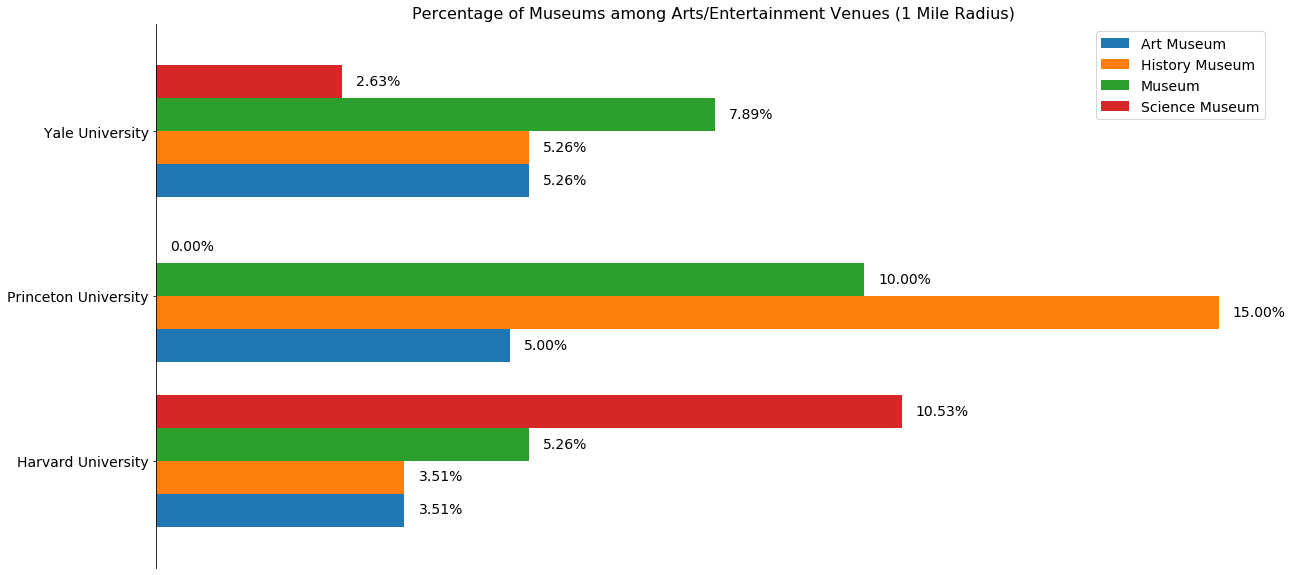

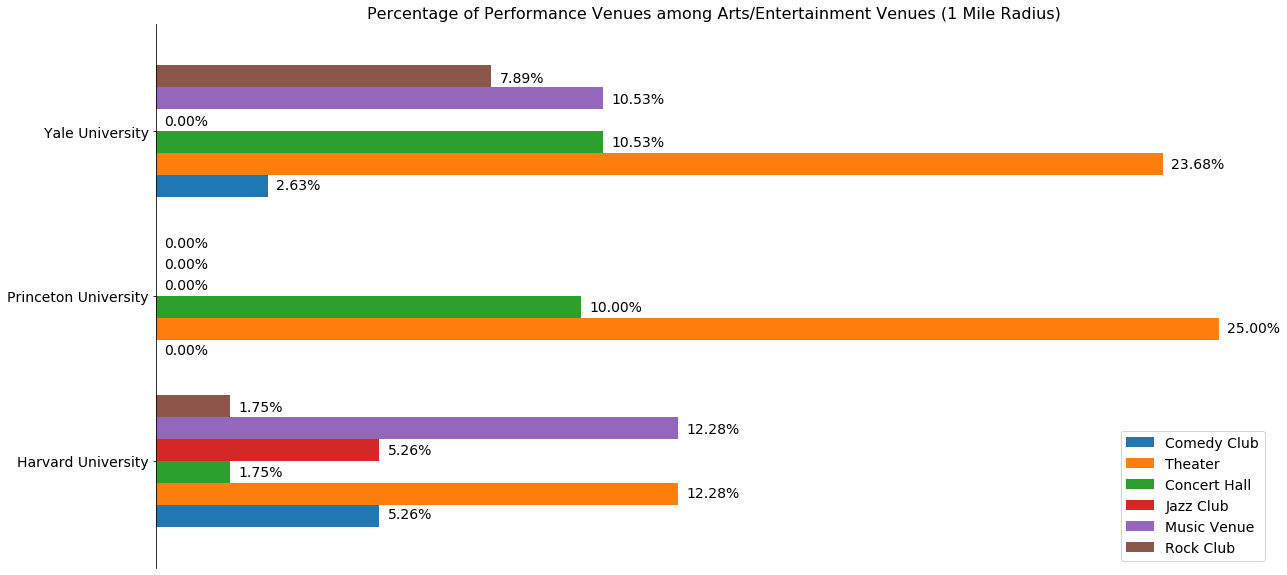

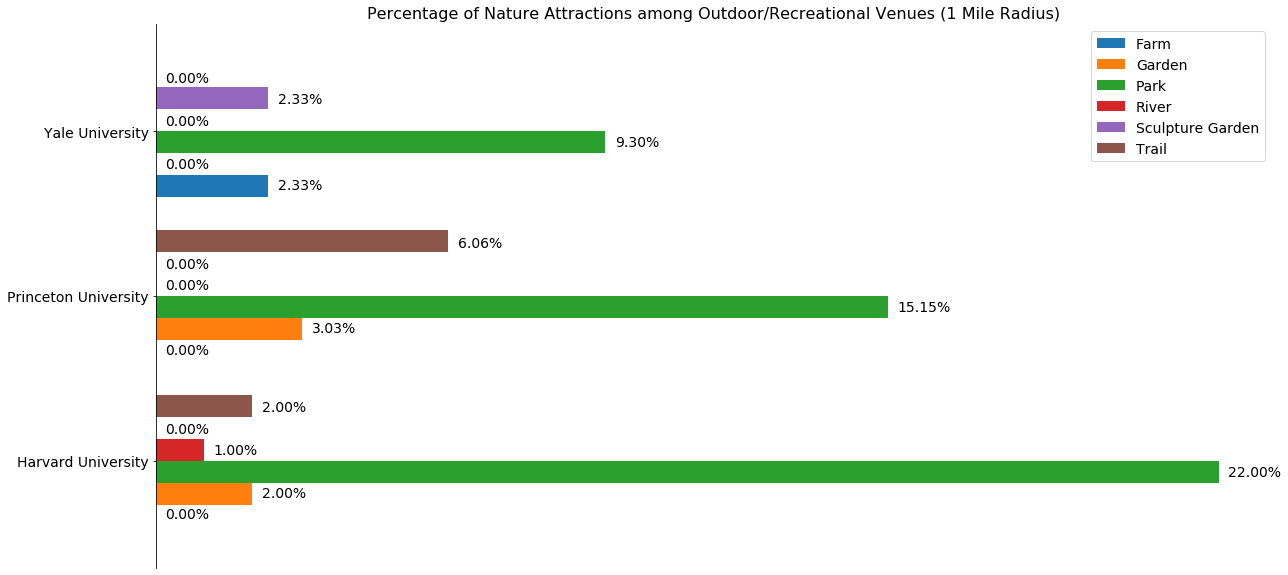

In [28]:

#----CHOOSE DIFFERENT VENUE TYPES TO COMPARE BASED ON PERSONAL PREFERENCES----#
#museums
df_museum =  grouped_arts[['Art Museum', 'History Museum', 'Museum', 'Science Museum']] #choose venue types to compare
ax = df_museum.plot(kind='barh', #change 'df_museum' to match name in previous line
          figsize=(20, 10), 
          width=.8,
         )
ax.set_title('Percentage of Museums among Arts/Entertainment Venues (1 Mile Radius)', fontsize = 16 )
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticklabels(df_museum.index) #change 'df_museum' to match name from above
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
for index, value in enumerate(df_museum.values): #change 'df_museum' to match name from above
    for i in range(0,4):
        ax.annotate("{:.2%}".format(value[i]), xy = (value[i] + .002, index - .32 + .2*i), fontsize=14)
        
#live performance venues
df_performance = grouped_arts[['Comedy Club', 
                   'Theater', 
                   'Concert Hall', 
                   'Jazz Club', 
                   'Music Venue', 
                   'Rock Club']]
ax = df_performance.plot(kind='barh',
          figsize=(20, 10), 
          width=.8,
         )
ax.set_title('Percentage of Performance Venues among Arts/Entertainment Venues (1 Mile Radius)', fontsize = 16 )
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticklabels(df_performance.index)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
for index, value in enumerate(df_performance.values):
    for i in range(0,6):
        ax.annotate("{:.2%}".format(value[i]), xy = (value[i] + .002, index - .35 + .13*i), fontsize=14)

#outdoor/nature venues
df_outdoor = grouped_outdoors[['Farm', 'Garden', 'Park', 'River', 'Sculpture Garden', 'Trail']]
ax = df_outdoor.plot(kind='barh',
          figsize=(20, 10), 
          width=.8,
         )
ax.set_title('Percentage of Nature Attractions among Outdoor/Recreational Venues (1 Mile Radius)', fontsize = 16 )
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticklabels(df_outdoor.index)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
for index, value in enumerate(df_outdoor.values):
    for i in range(0,6):
        ax.annotate("{:.2%}".format(value[i]), xy = (value[i] + .002, index - .35 + .13*i), fontsize=14)
#plt.show()

### Results of Comparisons
Based on the above comparisons, a student could make more informed decisions about which area they might enjoy most. For example, while Princeton has the highest percentage of museums among its arts/entertainment venues, our query only return 20 total arts/entertainment venues within a mile radius of Princeton (compared with 38 arts/entertainment venues near Yale, and 57 near Harvard). Thus, if a student places high value on having lots of museums to explore during their free time, the best choice would be Harvard, where 22.81% of the 57 arts/entertainment venues are museums (Yale has a similarly high percentage--21.04%, but fewer overall venues). 

Looking at live performance venues, 55.26% of Yale's 38 arts/entertainment venues are places where a student might see live music/entertainment. This seems much higher than Harvard's 38.58%, but taking into account the greater number of venues in Harvard the number of live performance venues is actually quite similar (22 in Harvard, 21 in Yale).

In terms of outdoor venues, Harvard once again returned the largest number of total outdoor/recreational venues (100 in total, as opposed to 43 near Yale and 33 near Princeton). Harvard also has the greatest number of unique types of outdoor venues (trails, rivers, parks, and gardens) and the highest percentage of nature attractions.

# V. Discussion

All of the above analysis was based on the wants/needs of a hypothetical student. This student wants to attend an elite university and enjoys going to museums, attending live performances, and exploring nature. According to this analysis, this hypothetical student should attend Harvard University; out of the "elite" cluster (Harvard, Princeton, and Yale) Harvard has the lowest acceptance rate, highest SAT scores, and highest graduation rate (it the most elite) and it also has the most museums, performance venues, and outdoor/nature attractions.

For a student with different values, the analysis could be modified to meet their needs. For example, a student with slightly lower SAT scores might be more interested in looking at clusters C (Brown and Dartmouth) and D (Cornell). That student might also be less interested in the arts and more interested in living somewhere with diverse cuisine. Another student might be a grad student with children looking to pay lower tuition and live close to lots of parks/playgrounds. All of these needs can be accommodated by changing the specific parameters of the within-cluster analysis section.

# VI. Conclusion

This is designed as a tool to help prospective students choose a university. It is currently set up only to compare the eight Ivy League universities, however the same data can just as easily be obtained on other groups of unversities. This tool is set up to provide a lot of freedom to the user; at each stage, the prospective student can make decisions based on their personal preferences. This is obviously incomplete data and is not meant to represent every factor a student might take into account when making a decision to attend a college; it is only intended to provide comarison and visualization of various features of multiple schools in order to influence a decision.